# LSTM Prediction for the Unemployment rate of California

writen by Duo

## Setting

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cpu")
 
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


## Dataset


In [4]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)

local file not found; accessing Google Drive


In [5]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [6]:
data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90


In [7]:
data.info

<bound method DataFrame.info of                 Area Type                           Area Name       Date  \
0                   State                          California 1976-01-01   
1                   State                          California 1976-01-01   
2                  County                  Los Angeles County 1976-01-01   
3                  County                  Los Angeles County 1976-01-01   
4       Metropolitan Area  Los Angeles-Long Beach-Glendale MD 1976-01-01   
...                   ...                                 ...        ...   
191122                MSA                   Yuba City, CA MSA 2022-04-01   
191123                MSA                   Yuba City, CA MSA 2022-05-01   
191124                MSA                   Yuba City, CA MSA 2022-06-01   
191125                MSA                   Yuba City, CA MSA 2022-07-01   
191126                MSA                   Yuba City, CA MSA 2022-08-01   

        Year    Month Seasonally Adjusted (Y/N) Status 

In [8]:
data["Area Name"].value_counts()

California                            1122
Los Angeles-Long Beach-Glendale MD    1122
Los Angeles County                    1122
Tuolumne County                        393
Hanford-Corcoran MSA                   393
                                      ... 
Hawaiian Gardens city                  153
Hawthorne city                         153
Hayfork CDP                            153
Hayward city                           153
Lakewood city                          153
Name: Area Name, Length: 1050, dtype: int64

In [9]:
data["Month"].value_counts()

January      16193
February     16193
March        16193
April        16193
May          16193
June         16193
July         16193
August       16193
September    16163
October      15140
November     15140
December     15140
Name: Month, dtype: int64

## Data Processing

In [10]:
def Area_chosen(place = 'California'):
    subData = data.loc[(data['Area Name'] == place)]
    subData = subData.loc[(subData['Seasonally Adjusted (Y/N)']=='N')]
    subData = subData.loc[(subData['Status (Preliminary / Final)']=='Final')]
    return subData


In [11]:
city = 'California' # chose your city in california or see the data of all state
subData = Area_chosen(city)

df = subData[['Date', 'Unemployment Rate']]
df.set_index(["Date"], inplace=True)
df = df.sort_index(ascending=True)
order = []
for i in range(6):
    j = 'R-' + str(i)
    df[j] = df['Unemployment Rate'].shift(i)
    order.append(j)
order.reverse()
df = df.dropna()
df = df[order]
df

,R-5,R-4,R-3,R-2,R-1,R-0
Date,,,,,,
1976-06-01,0.10,0.10,0.09,0.09,0.08,0.09
1976-07-01,0.10,0.09,0.09,0.08,0.09,0.10
1976-08-01,0.09,0.09,0.08,0.09,0.10,0.09
1976-09-01,0.09,0.08,0.09,0.10,0.09,0.09
1976-10-01,0.08,0.09,0.10,0.09,0.09,0.09
...,...,...,...,...,...,...
2022-04-01,0.05,0.05,0.06,0.05,0.04,0.04
2022-05-01,0.05,0.06,0.05,0.04,0.04,0.04
2022-06-01,0.06,0.05,0.04,0.04,0.04,0.04


In [12]:
S = StandardScaler()
Ss = S.fit_transform(df)
Ss = Ss.astype('float32')

In [13]:
y = Ss[:,-1]
X = np.delete(Ss,-1,axis=1)
#X = np.array(X.astype('float32'))
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle = False)

In [14]:
# ----------------- train -------------------
INPUT_FEATURES_NUM = 5
OUTPUT_FEATURES_NUM = 1
train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM)  # set batch size to 1
train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM)  # set batch size to 1
 
# transfer data to pytorch tensor
train_x_tensor = torch.from_numpy(train_x_tensor).to(device)
train_y_tensor = torch.from_numpy(train_y_tensor).to(device)

## LSTM Model

In [15]:
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) #
 
    def forward(self, _x):
        x, _ = self.lstm(_x) # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.linear1(x)
        x = x.view(s, b, -1)
        return x

In [16]:
lstm_model = LstmRNN(INPUT_FEATURES_NUM, 20, output_size=OUTPUT_FEATURES_NUM, num_layers=1).to(device)  # 20 hidden units

print('LSTM model:', lstm_model)
print('model.parameters:', lstm_model.parameters)
print('train x tensor dimension:', Variable(train_x_tensor).size())
 
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
prev_loss = 2000
max_epochs = 2000

for m in lstm_model.parameters():
    print(m.device)

LSTM model: LstmRNN(
  (lstm): LSTM(5, 20)
  (linear1): Linear(in_features=20, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(5, 20)
  (linear1): Linear(in_features=20, out_features=1, bias=True)
)>
train x tensor dimension: torch.Size([444, 1, 5])
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [17]:
for epoch in range(max_epochs):
    output = lstm_model(train_x_tensor)
    loss = criterion(output, train_y_tensor)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if loss < prev_loss:
        torch.save(lstm_model.state_dict(), f'lstm_model_{city}.pt')  # save model parameters to files
        prev_loss = loss
 
    if loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, max_epochs, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch + 1) % 100 == 0:
        print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, max_epochs, loss.item()))

Epoch: [100/2000], Loss:0.01479
Epoch: [200/2000], Loss:0.01230
Epoch: [300/2000], Loss:0.00987
Epoch: [400/2000], Loss:0.00654
Epoch: [500/2000], Loss:0.00446
Epoch: [600/2000], Loss:0.00306
Epoch: [700/2000], Loss:0.00244
Epoch: [800/2000], Loss:0.00191
Epoch: [900/2000], Loss:0.00272
Epoch: [1000/2000], Loss:0.00163
Epoch: [1100/2000], Loss:0.00162
Epoch: [1200/2000], Loss:0.00108
Epoch: [1300/2000], Loss:0.00090
Epoch: [1400/2000], Loss:0.00072
Epoch: [1500/2000], Loss:0.00059
Epoch: [1600/2000], Loss:0.00049
Epoch: [1700/2000], Loss:0.00045
Epoch: [1800/2000], Loss:0.00042
Epoch: [1900/2000], Loss:0.00102
Epoch: [2000/2000], Loss:0.00033


In [18]:
# prediction on training dataset
pred_y_for_train = lstm_model(train_x_tensor).to(device)
pred_y_for_train = pred_y_for_train.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
# ----------------- test -------------------
lstm_model = lstm_model.eval()  # switch to testing model
 
# prediction on test dataset
test_x_tensor = test_x.reshape(-1, 1,
                                   INPUT_FEATURES_NUM)
test_x_tensor = torch.from_numpy(test_x_tensor)  
test_x_tensor = test_x_tensor.to(device)
 
pred_y_for_test = lstm_model(test_x_tensor)
pred_y_for_test = pred_y_for_test.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

loss = criterion(torch.from_numpy(pred_y_for_test), torch.from_numpy(test_y))
print("test loss：", loss.item())

test loss： 0.6892348527908325


## Model Viz

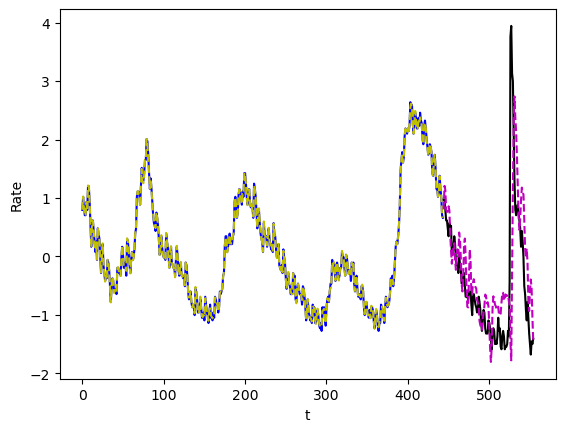

In [19]:
# ----------------- plot -------------------
plt.figure()
plt.plot(range(len(train_y)), train_y, 'b', label='y_trn')
plt.plot(range(len(train_y)), pred_y_for_train, 'y--', label='pre_trn')
 
plt.plot(range(len(train_y),len(train_y)+len(test_y)), test_y, 'k', label='y_tst')
plt.plot(range(len(train_y),len(train_y)+len(test_y)), pred_y_for_test, 'm--', label='pre_tst')
 
plt.xlabel('t')
plt.ylabel('Rate')
plt.show()
